# Result visualization

Here, we look at the results from the PRIDE ppp software and compare it to the UNR dataset

## Preprocessing to get the data in xarray

In [29]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

### read the output of the PRIDE PPP into pandas first:
* Add columns names
* Transform the modified julian date to date
* add station name
* Append all the days together
* create xarray using time and station as index

In [30]:
def read_raw_pos(path):
    columns_name = ['Mjd', 'Sod', 'E', 'N', 'Z', 'ALL', 'GPS', 'GLONASS', 'Galileo', 'BDS-2', 'BDS-3', 'QZSS', 'PDOP']
    df = pd.read_csv(path, sep="\s+", names=columns_name)
    df['time'] = pd.to_datetime((df['Mjd']+ 2400000.5), unit = 'D', origin = 'julian') + pd.to_timedelta(df['Sod'], unit='s')
    df['station'] = path[-4:]
    return df[['time', 'E', 'N', 'Z', 'PDOP', 'station']]

In [31]:
def read_all(station, year, days, path):
    list_df = []
    for day in days:
        try:
            list_df.append(read_raw_pos(f"{path}/{year}/{day}/enu_{year}{day}_{station}"))
        except FileNotFoundError as e:
            print(f"file not found: {e}")
    df = pd.concat(list_df)
    ds = df.set_index(['time', 'station']).to_xarray().resample(time='5min').mean()
    return ds

## Read some data

In [32]:
days = [str(i).zfill(3) for i in range(30, 150)]

In [33]:
ds_1 = read_all('albh', 2017, days, './results_ENU_v2/')
ds_1

<xarray.Dataset>
Dimensions:  (station: 1, time: 34560)
Coordinates:
  * station  (station) object 'albh'
  * time     (time) datetime64[ns] 2017-01-30 ... 2017-05-29T23:55:00
Data variables:
    E        (time, station) float64 -0.1769 -0.1715 -0.1723 ... -0.1538 -0.151
    N        (time, station) float64 -0.1496 -0.1504 -0.15 ... -0.1592 -0.157
    Z        (time, station) float64 0.0258 0.0313 0.0351 ... 0.029 0.0318 0.038
    PDOP     (time, station) float64 1.269 1.298 1.263 1.182 ... 1.2 1.258 1.27

In [35]:
ds_unr = xr.open_dataset("../GNSS_denoising/data/gnss_detrend_513stasv2.nc", chunks={'station': 1}).sel(station='ALBH', time=slice("2017-01-30", "2017-05-30")).load()
# ds_unr = xr.open_dataset("../GNSS_denoising/data/gnss_detrend_513stasv2.nc", chunks={'station': 1}).sel(station='ALBH', time=slice("2017-02-19", "2017-04-10")).load()

#ds_unr = ds_unr.resample(time='5min').mean()
ds_unr

<xarray.Dataset>
Dimensions:    (time: 34848)
Coordinates:
    station    <U4 'ALBH'
    longitude  float64 -123.5
    latitude   float64 48.39
    elevation  float64 31.77
    depth      float64 37.48
  * time       (time) datetime64[ns] 2017-01-30 ... 2017-05-30T23:55:00
Data variables:
    e          (time) float64 -0.1404 -0.1411 -0.1358 ... -0.1006 -0.0929
    n          (time) float64 -0.1429 -0.1374 -0.1326 ... -0.1254 -0.1342
    z          (time) float64 -0.01163 -0.008235 0.003128 ... -0.02536 -0.03575
    sig_e(m)   (time) float64 0.006716 0.006194 0.006058 ... 0.007091 0.007136
    sig_n(m)   (time) float64 0.0081 0.00747 0.007306 ... 0.008553 0.008606
    sig_v(m)   (time) float64 0.02561 0.02362 0.0231 ... 0.02702 0.02705 0.02721
    n_detrend  (time) float64 -0.02049 -0.01498 ... -0.0004708 -0.009356
    e_detrend  (time) float64 -0.02332 -0.02399 -0.01871 ... 0.01918 0.02683
    z_detrend  (time) float64 0.00131 0.004703 0.01607 ... -0.01301 -0.0234

## Plots some results, comparing with the UNR 5 min dataset

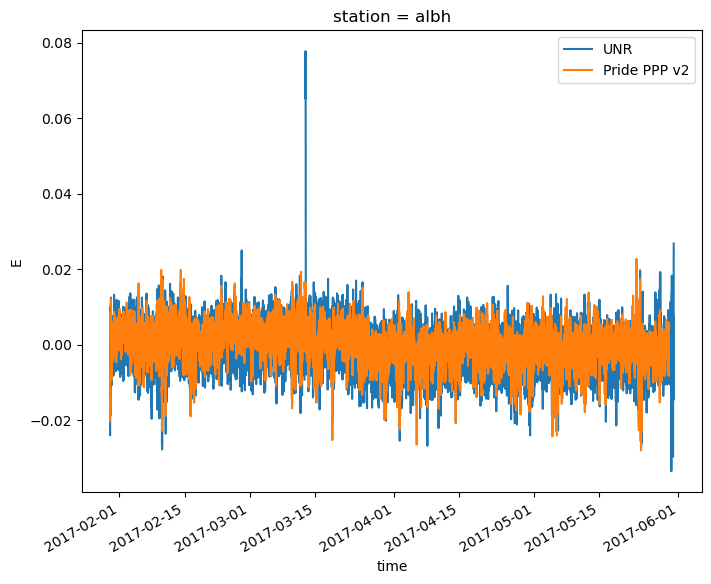

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
ds_unr.e_detrend.plot(ax=ax, label="UNR")
(ds_1.E - ds_1.E.mean()).plot(ax=ax, label="Pride PPP v2")
ax.legend(loc='upper right')

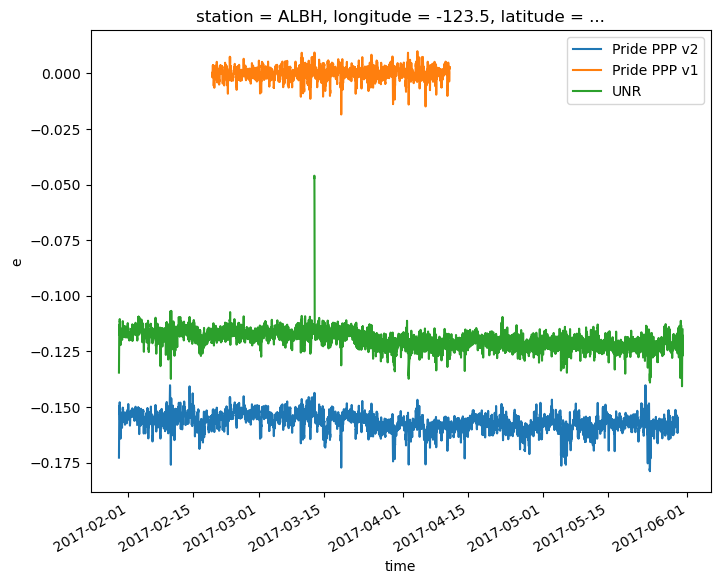

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
(ds_1.E).rolling(time=12).mean().plot(ax=ax, label="Pride PPP v2")
(ds_2.E).rolling(time=12).mean().plot(ax=ax, label="Pride PPP v1")
ds_unr.e.rolling(time=12).mean().plot(ax=ax, label="UNR")
ax.legend(loc='upper right')

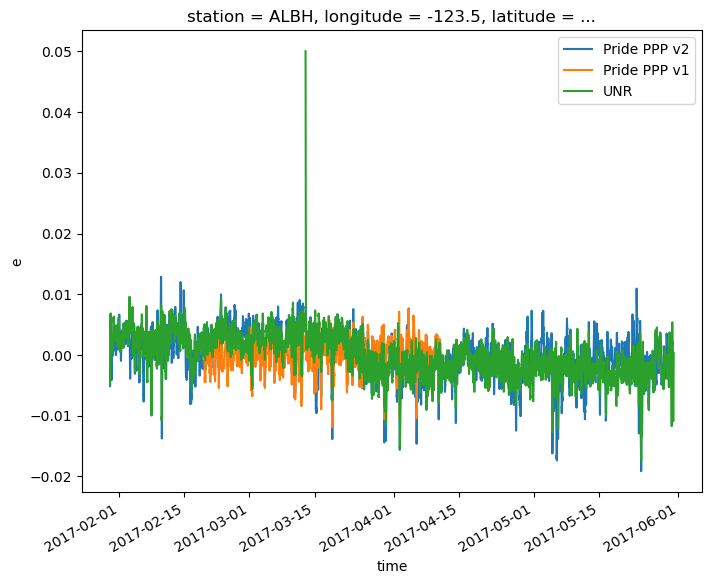

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
(ds_1.E - ds_1.E.mean()).rolling(time=30).mean().plot(ax=ax, label="Pride PPP v2")
(ds_2.E - ds_2.E.mean()).rolling(time=30).mean().plot(ax=ax, label="Pride PPP v1")
(ds_unr.e - ds_unr.e.mean()).rolling(time=30).mean().plot(ax=ax, label="UNR")
ax.legend(loc='upper right')

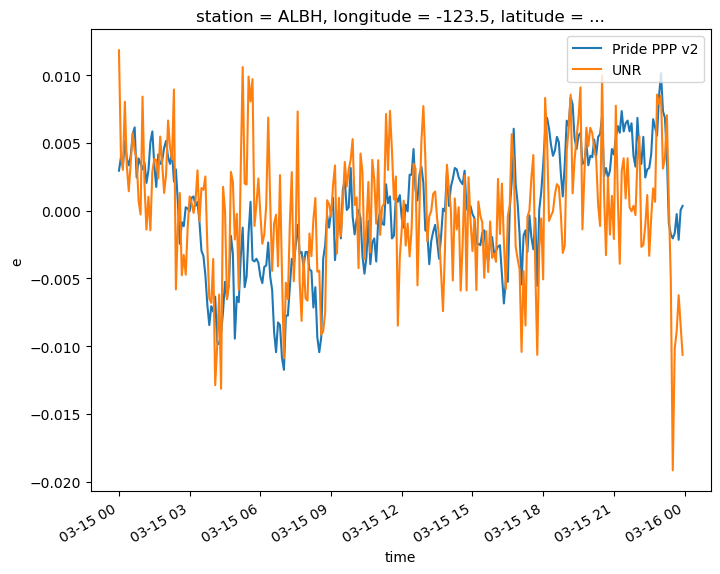

In [42]:
ds_1_sel = ds_1.sel(time=slice("2017-03-15", "2017-03-15"))
ds_unr_sel = ds_unr.sel(time=slice("2017-03-15", "2017-03-15"))

fig, ax = plt.subplots(figsize=(8, 6))
(ds_1_sel.E - ds_1_sel.E.mean()).plot(ax=ax, label="Pride PPP v2")
(ds_unr_sel.e - ds_unr_sel.e.mean()).plot(ax=ax, label="UNR")
ax.legend(loc='upper right')